### Import data

In [1]:
using Pkg
Pkg.instantiate()
using DrugResponseModel

# import data from the path
conc_l, pop, g2, g1, g2_0, g1_0 = setup_data("lapatinib");# in which:
# pop: population data
# g1, g2: g1 and g2 data
# initial: initial number of cells in g1 and in g2 at time 0

┌ Info: Precompiling DrugResponseModel [f46a7e40-ab32-11e9-0ff4-0323d592fbfd]
└ @ Base loading.jl:1273
  ** incremental compilation may be fatally broken for this module **



### Estimate 

In [2]:
# ODE optimization and estimation of the parameters
params_ode = zeros(4, 8)
for i in 1:8
    fit, params_ode[:, i] = ODEoptimizer([1.0, 1.0, 0.0, 0.0], i, g1, g2, g1_0, g2_0)
    print(fit, "\n")
end

271.61774997971213
382.0210969622665
611.0586992249254
1477.4171708775716
2854.240458083854
2316.4329037088755
652.3421447134992
665.8307514768104


In [3]:
params_ode[:,5]

4-element Array{Float64,1}:
 0.7290379486308016    
 0.6728157745900217    
 0.00010000032364091691
 0.6513057930883854    

### Turing

┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /home/farnazm/.julia/packages/Turing/xGrY5/src/inference/hmc.jl:547
Sampling 100%|███████████████████████████████| Time: 0:00:54


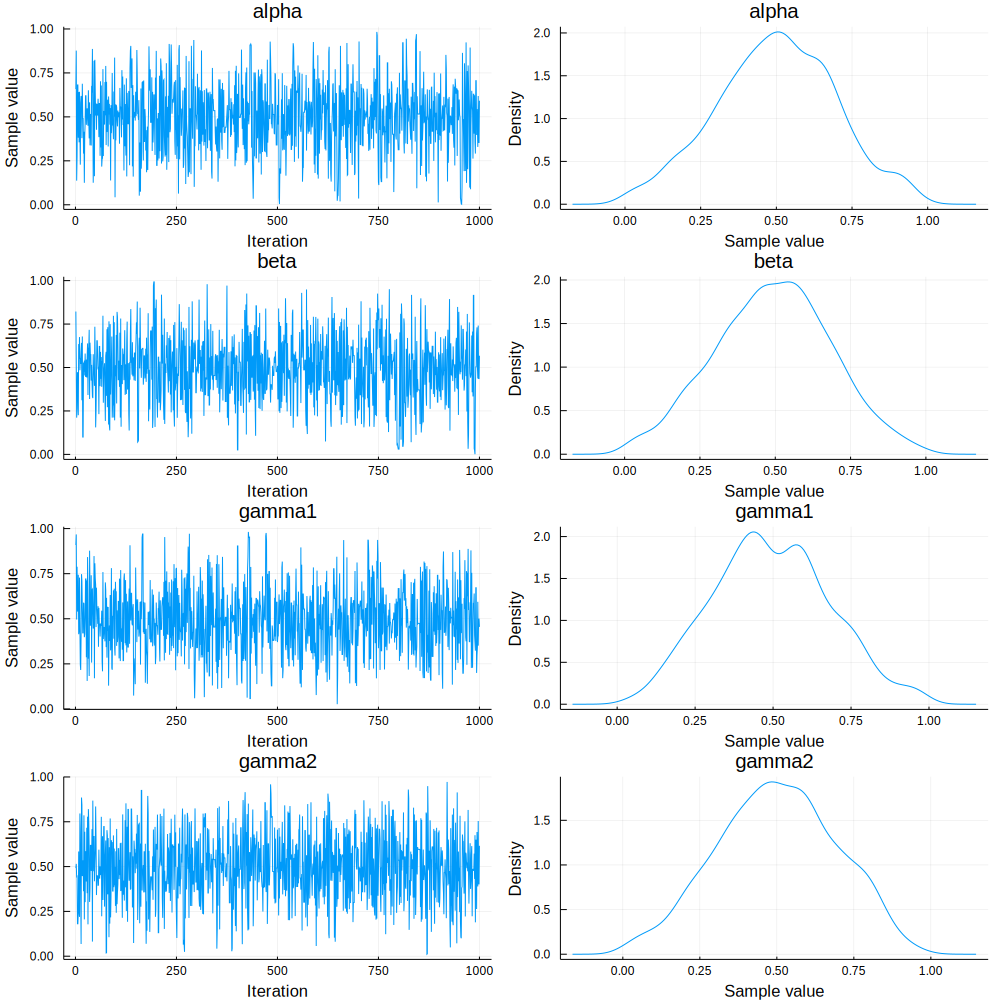

In [6]:
using StatsPlots
i=5
chain = turing(params_ode, g1_0, g2_0, i)
plot(chain)

In [7]:
savefig("turing.png")

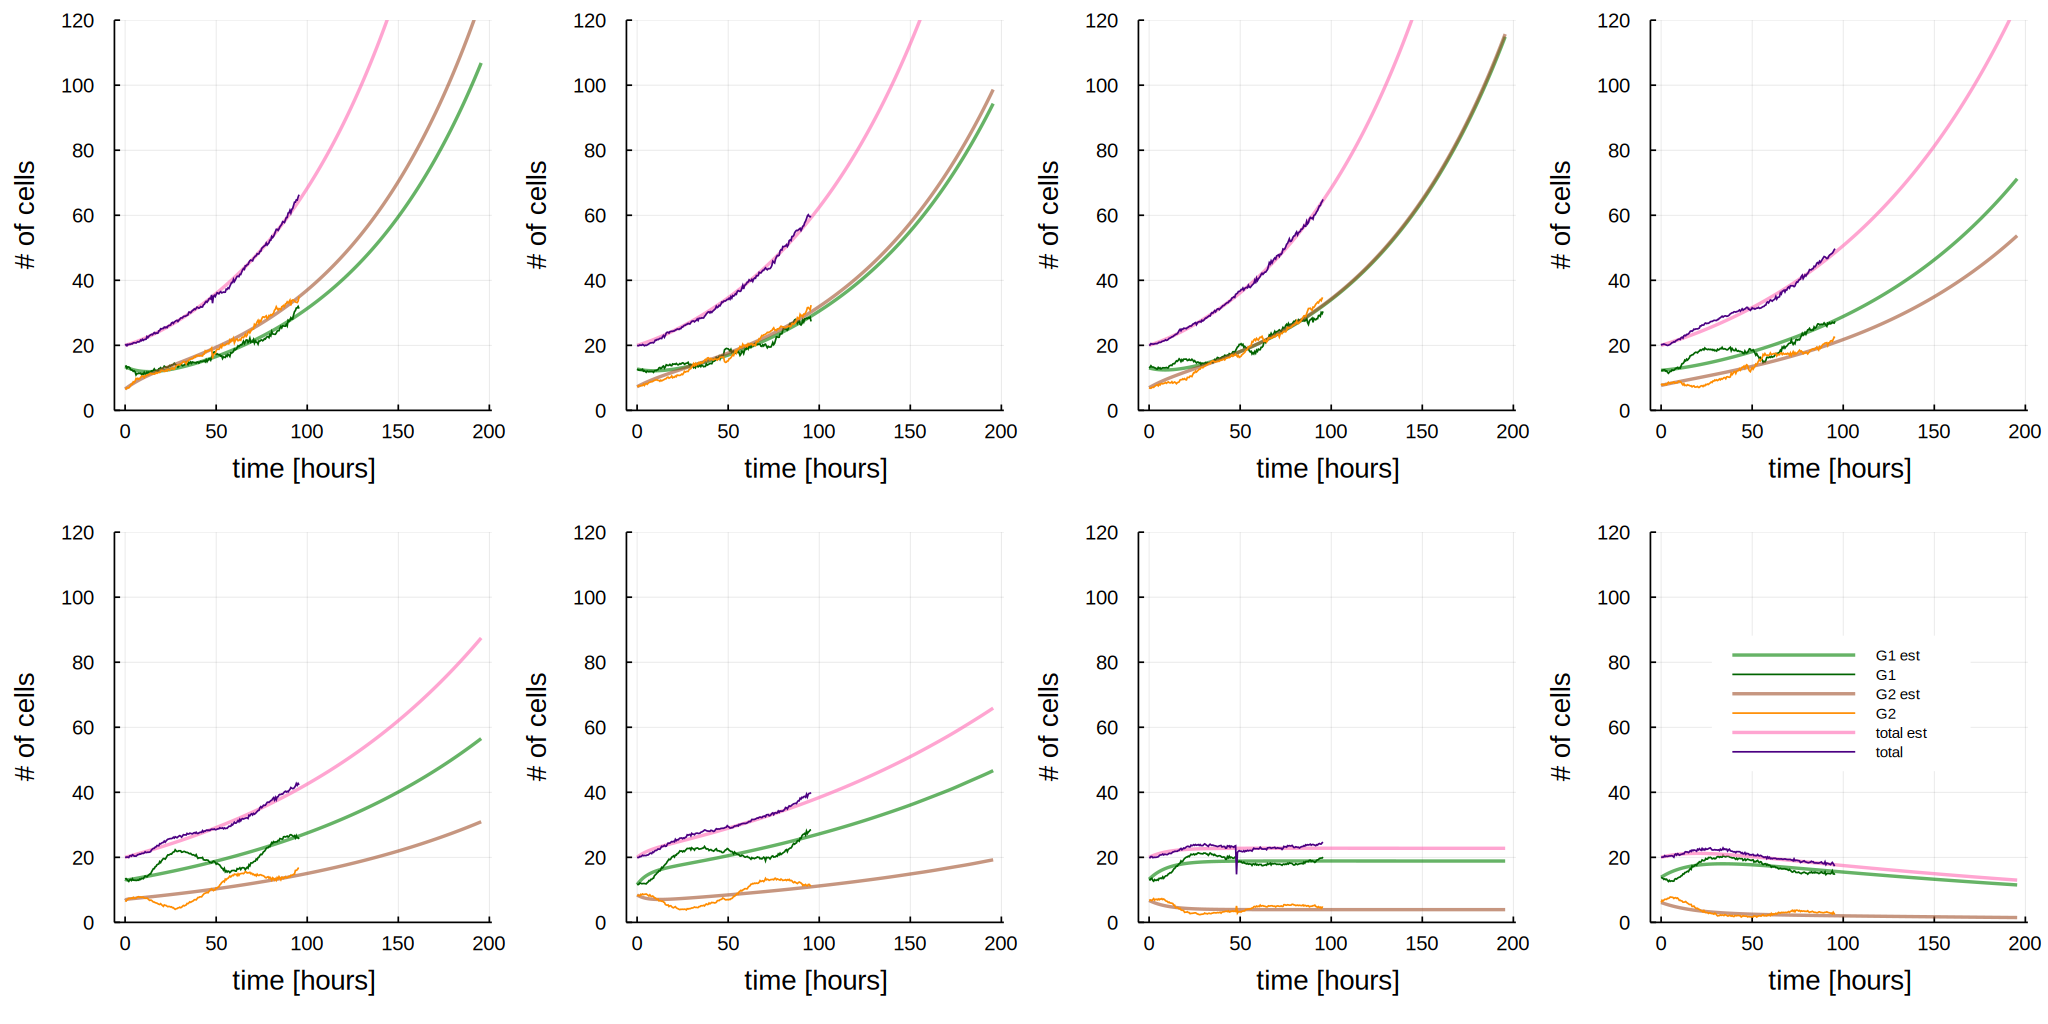

In [5]:
# plotting the fitted curves
ODEplot_all(params_ode, g1, g2, g1_0, g2_0, pop)